$$\mbox{Sebastian Schmid}$$

$$\mbox{s0543196}$$

# Einleitung

**Titanic: Machine Learning from Disaster**

Die Titanic, einst der Ingeneurstechnische Stolz einer ganzen Generation, als unsinkbar entworfen, sorgte für Entsetzen als diese bereits auf ihrer Jungfernfahrt nach einer Kollision mit einem Eisberg havarierte und sank.
Bei diesem Vorfall starben viele hunderte Menschen, doch einige überlebten die Havarie.  Ziel dieser Aufgabe ist es, anhand der Daten aus dem Unglück einen Entscheider zu entwickeln der bei einem definierten Set an Eingabevariablen berechnen soll, ob der betreffende Passagier überlebte oder nicht.



Hier wurde sich für einen Klassifikator nach dem Entscheidungsbaumprinzip entschieden. Um die Lösung möglichst gut abzubilden wurden die Entscheidungsbäume nach unterschiedlichen Algorithmen mit Zufallsparametern aufgebaut. Diese spannen einen Random-Forest auf, der Anschließend durch ein Dev-Test-Datenset verifiziert und aufgebessert wird.



Im Rahmen dieser Belegarbeit sollte ein Klassifikator implementiert werden, um an dem Wettbewerb  Titanic: [Machine Learning from Disaster](https://www.kaggle.com/c/titanic) von Kaggle teilzunehmen.


# Die verwendeten Python Module


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from math import log2
from random import randint, choice

import warnings
warnings.filterwarnings('ignore')
import json

import pickle
from tqdm import tqdm

from time import strftime

# Die Daten

## Beschreibung des Datensatzes

1. Trainigsdaten  -- Diese bestehen aus folgenden Daten:
    - PassengerId : Numerischer Index
    - Name: Der Name des Passagiers  (String)
    - Pclass. Die Passenger-Klasse (Numerisch)
    - Sex : Das Geschlecht des Passagiers (Binär)
    - Age : Das Alter des Passagiers (Numerisch fortlaufend)
    - SibSp: Anzahl von Geschwistern und  Ehegatten an Bord (Numerisch)
    - parch: Anzahl der Eltern und/oder Kinder (Numerisch)
    - Ticket:  Ticket nummer (String)
    - fare: Der Gezahlte Fahrpreis (numerisch fortlaufend)
    - cabin: Kabinennummer (String)
    - embarked: Der Zustiegshafen (Numerisch)
    - Survived: Überlebt (Binär)
2. Testdaten
    - Enthält die selben Datenklassen, bis auf Survived
    
    
Um den Algorithmus noch aufzubessern, wurde der Trainigsdatensatz in zwei Teile geteilt

1. train  -- DIe eigentlichen Trainigsdaten
1. dev_test -- Datensatz zur Verifikation der ermittelten Daten

In [3]:
# train_all = [train | dev_test]
train_all = pd.read_csv('./data/train.csv', index_col=0)
train = train_all[300:]
dev_test = train_all[:300]


# testdata -- needed to generate the sollution for the contest.
test = pd.read_csv('./data/test.csv', index_col=0)

final='Survived'

print(f"Size of the trainingsdata: {train.shape[0]}")
print(f"Size of the dev-test-data: {dev_test.shape[0]}")
train_all

Size of the trainingsdata: 591
Size of the dev-test-data: 300


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


## Orientierung im Datensatz

Bei einer ersten Überprüfung fiel auf, dass es zum einen ein starkes Überlebensungleichgewicht in den Geschlechtern zu sehen ist.Außerdem sind die Überlebenden und die Gestorbenen nicht gleich verteilt.  Ca. 62% haben die Havarie nicht überlebt.

Stellt man den Fahrpreis und das Alter des Fahrgastes gegenüber, ist eine starke Verdichtung in einem Bereich zu sehen, während die Dichte der daten in den oberen und rechten Rändern abfällt.
Eine Warscheinlichkeit über den jeweiligen Ausgang der Fahrt lässt sich daraus aber nicht ableiten.

In [3]:
train_all[train_all['Survived'] == 1].shape[0] / train_all[train_all['Survived'] == 0].shape[0]

0.6229508196721312

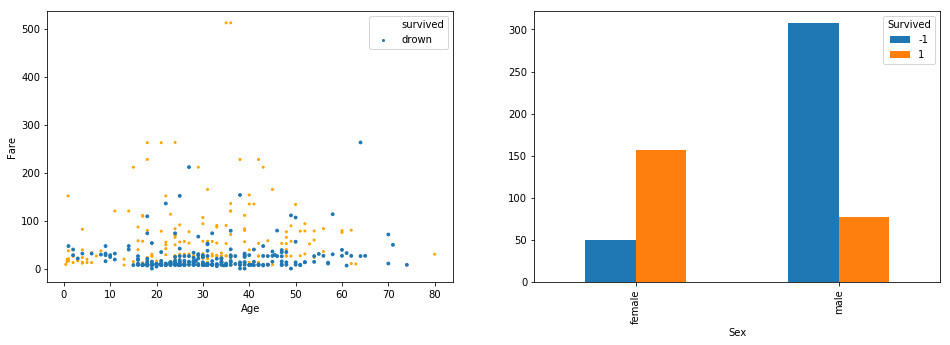

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 5)

ax = train.plot(kind='scatter', x='Age', color='Orange', 
                y='Fare', s=4*train['Survived'], 
                label='survived', ax=axes[0,])
ax = train.plot.scatter( x='Age', y='Fare',  
                         s=4*(1-train['Survived']),
                        label='drown', ax=ax)

ax = train.groupby(['Sex', final]).size().unstack().plot(
    kind='bar', ax=axes[1,])

# Verwendete Algorithmen


Die Entscheidungsbäume verwenden eine Reihe von Algorithmen um die Entscheidung über die nächsten Äste treffen zu können. Diese werden im Folgenden vorgestellt.  


## Gini-Index

Der Gini-Koeffizient ist ein Maß zur Darstellung von Ungleichverteilungen (Impurity).

$$
    \mbox{Gini}(S) = 1- \sum\limits_i p_i^2
$$

$$
    \mbox{Gini}(S, A)  = \sum\limits_i \frac{|s_i|}{|S|} \cdot \mbox{Gini}(S)
$$

In [5]:
def gini(S, A=None):
        
    if A == None:
        return 1-sum( 
            [(S[S[final] == o].size / S.size)**2 for 
             o in  pd.unique(S[final])] 
        )
    
    return sum( [ ( S[A][S[A] == p].size / S[A].size ) * 
                 gini(S[S[A] == p]) for p in pd.unique(S[A])]  )

## Entropy

Die Entroy ist ein mathematisches Maß um die Ungewissheit eines Trainings-sets zu ermitteln. Im Umkehrschluss bedeutet dies, dass wenn dieses Verringert wird, kommt man der Entscheidung näher.

$$
E(S) = - \sum\limits_{i=1}^{n} p_i \cdot \log_2(p_i) 
$$

In [6]:
def entropy(S, *args):
            
    outcomes = pd.unique(S[final])
    ent = lambda p: 0 if p == 0 else p * log2(p) 
    
    return -sum([  ent( S[S[final] == o].size / S.size ) 
                 for o in outcomes ])


## Information

Die Information ist eine kennzahl über den Informationsgehalt einer Subklasse.

$$
I(S, A) = - \sum\limits_{i=1}^{n} \frac{|S_i|}{|S|} \cdot E(S_i)
$$

In [7]:
def information(S, A):
    partitions = pd.unique(S[A])

    return sum([( S[A][S[A] == p].size / S[A].size ) * 
            entropy( S[S[A] == p]) for p in partitions])

## Information Gain

Um das Maß der Information noch zu verfeinern, kann Information Gain ermittelt werden. So wird ermittelt, wie groß der Verhältnis von Entropyverlust und informationsgewinn ist.
$$
\mbox{Gain}(S, A) = E(S) - I(S,A)
$$

In [8]:
def gain(S, A):     
     return entropy(S) - information(S, A)

## Instrinsic Information

Das Maß der Intrinsic Information verfeinert dieInformation. 

$$
\mbox{IntI}(S,A) = - \sum\limits_i \frac{|S_i|}{|S|} \cdot \log_2\left(\frac{|S_i|}{|S|}\right)
$$

In [9]:
def intrinsic_information(S, A):
    
    return -sum([0 if S[A][S[A] == p].size  == 0    
                 else ( S[A][S[A] == p].size / S[A].size ) * 
                log2( S[A][S[A] == p].size / S[A].size )  
                 for p in pd.unique(S[A])])

## Gain Ratio

$$
GR(S,A) = \frac{\mbox{Gain}(S,A)}{\mbox{IntI}(S,A)}
$$

In [10]:
def gain_ratio(S, A):
    # Question: how to make this less ugly
    if intrinsic_information(S,A) == 0:
        return 0
    return gain(S,A) / intrinsic_information(S,A)

# Feature extraction

## Attribute aus dem Namen

Im Englischen ist der soziale Rang aus dem Namen ableitbar. Der Namenszusatz (Mr, Mrs, Master, Duke ...) erlaubt also eine Klassifikation des sozialen Standes abhängig vom Geschlecht des Passagiers.

Seltene Klassen wurden in other zusammengefasst.


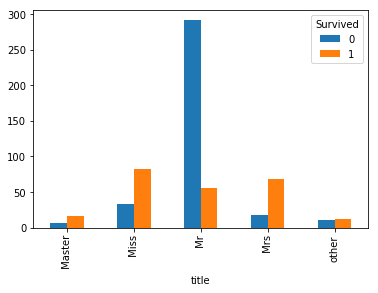

In [11]:

def status_title(data):

    # Extract title from name.
    # - The value is right of the comma and ends with a point
    data['title'] = data['Name'].map(
        lambda n: n.split(',')[1].split('. ')[0])

    counts = data.title.value_counts()

    # We group all titles if their occurancies is 
    # smaler then 10.
    data['title'] = data['title'].map(
        lambda t: t if counts.get(t) > 9 else 'other')
    
    return data

ax = (status_title(train).groupby(['title', final])
      .size()
      .unstack()
      .plot(kind='bar'))

## Extraktion des Decks aus der Kabinennummer

In der Ticketnummer lässt sich das Deck der Kabine ableiten. Dieses wird extrahiert und als deck gespeichert.

Es zeigt sich eine starke Häufung von nicht-Überlebenden bei der Klasse derer, deren Kabinennummer nicht mehr ermittelt werden konnte.


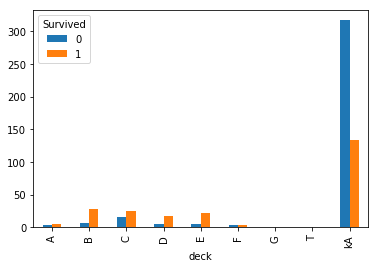

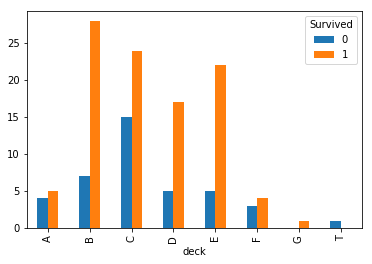

In [12]:
def extract_deck(S):

    S['deck'] = S['Cabin'].map(
        lambda c: list(c)[0] 
        if not pd.isnull(c) else 'kA')
    return S

ax = (extract_deck(train)
      .groupby(['deck', final])
      .size()
      .unstack()
      .plot(kind='bar')
     )

ax = (extract_deck(train)[extract_deck(train)['deck'] != 'kA']
      .groupby(['deck', final])
      .size()
      .unstack()
      .plot(kind='bar')
     )


## Klassifikation fortlaufender Werte

Die Datenklassen Age und Fare sind forlaufend. Um diese einer Klassifikatioons zuzuführen, müssen diese in Klassen eingeteilt werden.

### Gini-Boarder

Die Klassengrößen werden hier dabei mit dem Gini-Algorithmus ermittelt.


In [13]:
def classified(S, A):
    _d = S[ [final, A] ].sort_values(by=A).dropna()
    _d[A] = _d[A].map(lambda a: int(a)) 
    
    
    borders = [None, None, None, None]
    borders[1] = gini_border(_d, A)
    borders[0] = gini_border(_d[_d[A] < borders[1]], A)
    borders[2] = gini_border(_d[_d[A] >= borders[1]], A) 
    borders[3] = gini_border(_d[_d[A] >= borders[2]], A)
    
    ranges = [list(range(0, borders[0])), 
              list(range(borders[0]+1, borders[1])),
              list(range(borders[1]+1, borders[2])), 
              list(range(borders[2]+1, borders[3])), 
              list(range(borders[3]+1, 333))]
    
    cats = {str(i): '' if len(ranges[i]) <= 0 else 
            '%s,%s' % (ranges[i][0], ranges[i][-1]) 
            for i in range(5)}
    cats[''] =  'kA'
    
    return S[A].map( 
    #  - The comprehension should only return one or no value. 
    #  - Using join to unpack the values - robust in handling 
    #    empty lists.
        lambda a: cats[''.join([str(i) 
                                for i, ran in enumerate(ranges) 
                                if a in ran] ) ] )
    

In [14]:
def gini_border(S, A, classes=None):
    
    if classes == None:
        classes = randint(2, int(log2(S.shape[0])))
        
    rows = S.shape[0]
    step = int(rows / classes)
    candidates = [S.iloc[c][A] for 
                  c in range(step, S.shape[0], step)]
    final = 'Survived'
    
    _A = list()
    for c in candidates:
        S['cclass'] = S[A].map(lambda a: int(a) < c)
        _A.append(gini(S, 'cclass'))
        
    return candidates[np.argmin(A)]

### Randomisierte Klassenanzahlen

Um eine höhere Diversität in den Algorithmus zu bekommen, wurden die Klassengrößen des durch den Gini-Algorithmus untersuchten Klassen randomisiert. Somit gibt der Algorithmus jedesmal ein leicht abgeändertes Ergebnis aus. 

Sowohl für ```Age``` als auch für ```Fare``` sind Plots zu sehen, die die Umverteilung der so ermittelten Klassengrenzen anzeigen.


#### Klassifikation des Alters

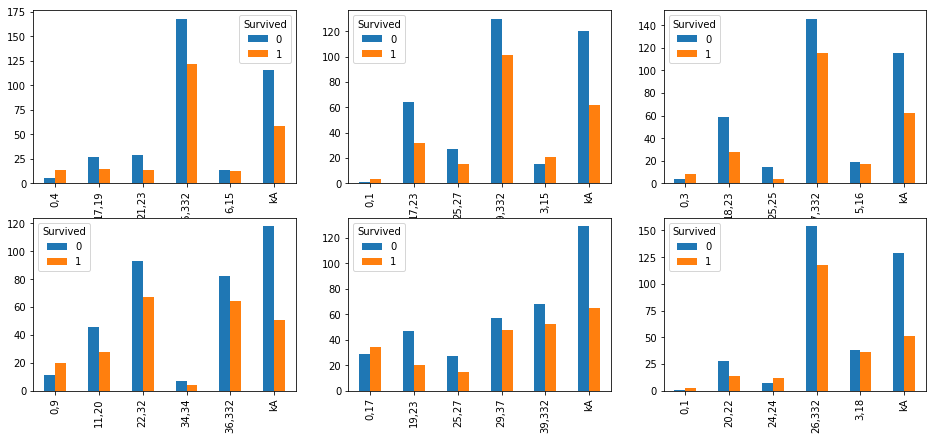

In [15]:
def plot_classified_age(data):
    fig, axes = plt.subplots(nrows=2, ncols=3)
    fig.set_size_inches(16, 7)
    for x in range(2):
        for y in range(3) :
            train['classified_age'] = classified(train, 'Age')

            ax = (train.groupby(['classified_age', final])
            .size()
            .unstack()
            .plot(kind='bar', ax=axes[x, y] ))

            ax.set_xlabel('')
    plt.show()
plot_classified_age(train)

#### Klassifikation des Preises

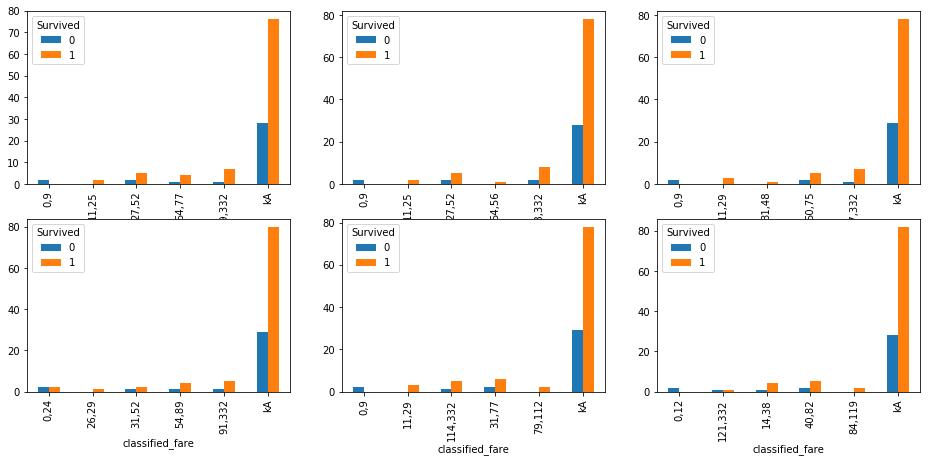

In [16]:
def plot_classified_fare(data):
    fig, axes = plt.subplots(nrows=2, ncols=3)
    fig.set_size_inches(16, 7)
    for x in range(2):
        for y in range(3) :
            data['classified_fare'] = classified(data.dropna(), 'Fare')
            ax = (data.groupby(
                ['classified_fare', final])
              .size()
              .unstack()
              .plot(kind='bar',  ax=axes[x, y]))
    plt.show()  
plot_classified_fare(train)

## Entfernen aller fortlaufenden und Overfittenden Datensätze

Die folgenden Datensätze werden aus dem Datensatz entfern, um so einem Overfitting der Algorithmen vorzubeugen.

In [17]:
ignore = ['Name', 'Ticket', 'Cabin', 'Fare', 'Age']

In [ ]:
[0 if a == 0 else a for a in A if not a  == b]

In [18]:
def process_datafitting(data):
    
    data = status_title(data)
    data = extract_deck(data)
    data['classified_age'] = classified(data, 'Age')
    data['classified_fare'] = classified(data, 'Fare')
    # Easier calculating with sums over 1 and -1
    data['Survived'] = data['Survived'].map(
        lambda x: -1 if x == 0 else x)
    
    return data.drop(ignore, axis=1)
    


---

# Aufbau der Entscheidungsbäume

In [19]:
# λ-function to execute a given mathematical function. 
#   and returning a dictionary dataset.
#   - needs a function of the type f(S, A)
_exec = lambda f, data : {col: f(data, col) 
                          for col in data.columns 
                          if not col == final}

### Berechnung der Werte der Entscheider

In der folgenden Tabelle ist eine Übersicht der Entscheidungsalgorithmen und der verschiedenen Klassen zu sehen. Es ist außerdem zu erkennen, dass sich die Entropie und Informationsverluste überall im erwarteten Rahmen bewegen. Es scheint kein stark  overfittendes Element vorhanden zu sein. 




In [20]:

desc_map = pd.DataFrame( dict(
    gain = _exec(gain, data), 
    information = _exec(information, data), 
    gini = _exec(gini, data),
    gain_ratio = _exec(gain_ratio, data),
    intrinsic_information = _exec(intrinsic_information, data),
) )

desc_map

,gain,gain_ratio,gini,information,intrinsic_information
Embarked,0.036233,0.033263,0.454132,0.932293,1.089277
Parch,0.043358,0.038407,0.451147,0.925167,1.128908
Pclass,0.126195,0.086412,0.396490,0.842331,1.460389
Sex,0.219416,0.234847,0.336659,0.749109,0.934295
SibSp,0.048948,0.038239,0.449510,0.919578,1.280055
classified_age,0.010038,0.004666,0.471624,0.958488,2.151160
classified_fare,0.048791,0.045118,0.449296,0.919734,1.081409
deck,0.108368,0.078601,0.407432,0.860158,1.378711
title,0.253589,0.152178,0.317804,0.714937,1.666396


### Entscheidungswege

Hier ist zu erkennen, an welchem Datum die verschiedenen Entscheider jeweils teilen würden.
Es zeigt sich, dass unterschiedliche Algorithmen sich für unterschiedliche Wege entscheiden würden, einen Entscheidungsbaum aufzubauen.

In [21]:
{algo: desc_map[algo].argmin() for (algo) in desc_map.keys()}

{'gain': 'classified_age',
 'gain_ratio': 'classified_age',
 'gini': 'title',
 'information': 'title',
 'intrinsic_information': 'Sex'}

# Generierung der Entscheidungsbäume

## Die Baumschule

Im folgenden ist der Algorithmus für das erstellen eines Entscheidungsbaumes zu sehen. 

Dieser lässt sich stark randomisieren, oder auf einen Algorithmus feststellen.
Wird sich für den randomisierten Weg entschieden, so wird jede dritte Entscheidung außerdem per Zufall entschieden. Dies geschiet um eine möglichst hohe Diversität der Decisiontrees zu erhalten.

Der rekursive Ablauf hat folgende Abbruchbedingungen:

1. Das Untersuchte Datum besteht nur noch aus einem einzigen Datensatz
1. Alle betreffenden Datensätze zeigen auf das selbe Ergebnis (Survived: 1 / 0)
1. Es gibt keine Klassen mehr für die Unterteilung


Die Rückgabe ist ein Dictionary, zur Darstellung der Baumstruktur.

### Codierung auf -1 und 1
Um die spätere Berechnung zu vereinfachen wurde das Feld Survived umcodiert. Ertrunken ist nun -1, überlebt ist 1. Fehlerfälle oder unklare Entscheidungen werden mit 0 codiert.

So kann der Entscheider vereinfacht werden. Bei der Entscheidung über die Bäume $t \in T$ reduziert sich die Abfrage auf: 
$$
x^{(m)} = \sum\limits_1^n t_n^{(m)}; \,\,\,\,
\begin{cases}
     x^{(m)} \leq 0 & \mbox{Survived} = 0 \\
     \mbox{sonst} & \mbox{Survived} = 1
   \end{cases}
$$


In [22]:
def rec_tree_farm(_df, algorithm=None):
    """Recursive spawning of a decisiontree.
    
    _df: Fully classified and elaborate Dataframe.
    algorithm: Mathematical function to determine decisions.
    
    returns: dict with the fully spawned decisiontree.
    """
    
    if algorithm == None:
        ## randomizer
        alg = choice([gain, gain_ratio, gini, 
                      information, intrinsic_information])
        branches = pd.Series(_exec(alg, _df))
    else:
        branches = pd.Series(_exec(algorithm, _df))
   
    # If there just one row, there is nothing more to descide  
    # This extraclause has to be because singleline 
    # Series do have no argmin.
    if branches.shape[0] <= 1:
        
        out = _df[final].unique()
        return {'Survived': 
                int(out) if out.shape[0] <= 1 
                else int(out.sum()) }
    
    # Getting the best result by argmin.
    # Every third will be choosen by random
    dice = 3
    branch = (branches.argmin() 
              if randint(1,dice) != dice or not algorithm == None
              else branches[
                  branches == choice(branches)].index[0])
    
    if _df[final].unique().shape[0] <= 1:
        out = _df[final].unique()
        return {'Survived': 
                0 if out.shape[0] <= 0 
                else int(_df[final].unique()) }

    # Here is the recursive call to build the tree.
    # Getting the current branch with his subbranches ...
    return {branch: {str(b): 
                     # ... directing to the recursive calls ...
                     rec_tree_farm(
                         #  ... if the rows inside our branch ...
                         _df[_df[branch] == b].drop(
                             # ... and drop the current branch...
                             [branch, ], axis=1), algorithm) 
                     # ... of all subbranches of branch.
                     for b in _df[branch].unique()}}



## Beispielhafte Darstellung von Entscheidungsbäumen

Hier werden einige so ermittelte Decisiontrees exemplarisch aufgezeigt. Diese wurden als Json extrahiert und über einen Webdienst dargestellt.

- [Beispiel Gain Ratio](http://www.jsoneditoronline.org/?id=320ff80d062b13667ebef4525e7024af)
- [Beispiel Intrinsic Information](http://jsoneditoronline.org/?id=7f70b8c86a5a23c8a566536e09be0b14)
- [Beispiel randomisierter Tree](http://jsoneditoronline.org/?id=320ff80d062b13667ebef4525e853e3d)

# Random Forrest

Der folgende Block erstellt ein Set aus 300 randomisierte Entscheidungsbäume und speichert diese als Picklefile ab. Da die Berechnung einige Zeit in Anspruch nehmen kann, können die Daten so wieder geladen werden.

In [23]:
from time import time

generate = False
size = 300

if generate:
    a = time()
    random_forrest = [rec_tree_farm(data) for _ in tqdm(range(size))]
    print('Generated %s trees in %s secs.' % (size, time()-a) ) 
    pickle.dump( random_forrest, open("randforrest_%s.p" % size, "wb" ) ) 
else:
    random_forrest = pickle.load( open( "randforrest_300.p", "rb" ) )

# Traversierung der Bäume

Um Entscheidungen aus anderen Datensätzen abzuleiten müssen die Bäume traversiert werden.

Die folgenden Funktionen haben die Aufgabe die Entscheidungen so zu ermitteln. Da die Klassengrenzen in den oben genannten Algorithmen nicht fortlaufend waren müssen daten die "zwischen die Klassen fallen" einer Klasse zugeordnet werden. Dies übernimmt die Funktion re_classify mithilfe der Funktion find_nearest.


Die Funktion traverse_tree traversiert den Baum rekursiv und leitet daraus die Entscheidungen ab.

In [24]:
# The calssified data has to be rebuilt with the classboarders
classified_data = ['classified_age', 'classified_fare']

def find_nearest(array, value):
    """stolen from: 
    http://stackoverflow.com/questions/\
    2566412/find-nearest-value-in-numpy-array"""
    if array.shape[0] <= 1:
        return array
    
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def extract_borders(key, tree): 
    return ['kA' if c == 'kA' else c.split(',') 
            for c in tree[key].keys()]

def re_classify(passenger, borders, key):
     
    class_map = {'classified_age': 'Age', 'classified_fare': 'Fare'}
    continues_data = passenger[class_map[key]]

    if list(borders) == ['kA']:
        return 'kA'
    
    borders = [b for b in borders if not b == 'kA']
    
    lower_limits = np.array([int(a[0]) for a in borders])
    upper_limits = np.array([int(a[1]) for a in borders])
    
    lb = np.argwhere(
        lower_limits == find_nearest(lower_limits, continues_data))
    rb = np.argwhere(
        upper_limits == find_nearest(upper_limits, continues_data))

    if lb == rb:
        return ','.join(borders[lb[0][0]])
    else:
        # draw a coin to decide the left or right border
        if randint(0,1) == 0:
            return ','.join(borders[lb[0][0]])
        return ','.join(borders[rb[0][0]])

In [25]:
def traverse_tree(tree, passenger):
    
    for key, value in tree.items():
        if key == final:
            return int(value)

        if key in classified_data:
            borders = extract_borders(key, tree)
            passenger[key] = re_classify(passenger, borders, key)
        
        try:
            value[str(passenger[key])]
        except KeyError:
            continue
            
        return traverse_tree(value[str(passenger[key])], passenger)

# Testing the solution

Algorithmus für das Testen der Lösung

In [26]:
def _outcome(tree, passenger):
    o = traverse_tree(tree, dict(passenger))
    return 0 if o == None else o


def get_forcasts(trees, test_data):
    ergs = pd.DataFrame([ 
        # from all trees of the randomforest
        # .. pointing all indizies to the outcome  of the row
        # .. in the descition-tree.
        {idx: _outcome(tree, dict(row)) 
         for idx, row in test_data.iterrows()} 
        for tree in trees]).T
    
    # if the sum of the cols > 0 survived, 
    # else drown to death.
    return pd.DataFrame({idx: 0 if sum(list(row)) < 0 else 1 
              for idx, row in ergs.iterrows()}, 
             index=['results']).T.join(test_data)

def get_forecast_precision(trees, test_data):
    df = get_forcasts(trees, test_data)
    return df[ 
        df['results'] == df['Survived'] 
    ].shape[0] / df.shape[0]

In [27]:
test_data = dev_test
test_data = status_title(test_data)
test_data = extract_deck(test_data)

In [28]:
df = get_forcasts(random_forrest, test_data)

## Ein einzelner Descition-Tree

Hier ist exemplarisch die Genauigkeit der Algorithmen mit einem einzigen Enscheidungsbaums aufgezeigt.

In [29]:
get_forecast_precision([rec_tree_farm(data), ], test_data)

0.6166666666666667

## Random Forrest von 300 Bäumen

Die Genauigkeit über einen Random-Forrest mit 300 Bäumen ist im folgenden Codeblock zu erkennen.

In [30]:
precision = get_forecast_precision(random_forrest, test_data)
print("Presition of the prediction of the dataset: %s" % precision)

Presition of the prediction of the dataset: 0.75


## Error Analyse

Durch den Testdatensatz können die Lösungen bewertet werden. Haben diese einen geringeren Score als 0.76, werden diese Bäume verworfen und nicht in die Aufgabenabgabe mit eingearbeitet.

In [31]:
to_lumber = [i for i, tree in enumerate(random_forrest) 
 if get_forecast_precision([tree,], test_data) > 0.63]
good_trees = [tree 
              for i, tree in enumerate(random_forrest) 
              if i in to_lumber]

print("croped %s trees."  % (len(random_forrest) - len(good_trees)))

croped 179 trees.


Durch diese Transformation konnte die Genauigkeit auf folgendes Maß angehoben werden.

In [32]:
precision = get_forecast_precision(good_trees, test_data)
print("Presition of the prediction of the dataset: %s" % precision)

Presition of the prediction of the dataset: 0.7666666666666667


# Export der Lösung

In [33]:
test_data = test
test_data = status_title(test_data)
test_data = extract_deck(test_data)

In [34]:
accurcy = precision
timestamp = strftime("%Y-%m-%d_%H-%M-%S")


def extract_forecast_table(trees, test_data):

    return pd.DataFrame(
        {idx: 0 if sum(list(row)) <= 0 else 1 
             for idx, row in pd.DataFrame([ 
                 {idx: _outcome(tree, dict(row)) 
                  for idx, row in test_data.iterrows()} 
                 for tree in trees]).T.iterrows()}, 
            index=['Survived']).T

my_solution = extract_forecast_table(good_trees, test_data)
my_solution['PassengerId'] = my_solution.index
my_solution.to_csv(f'solution_{accurcy}_{timestamp}.csv', index=False)

In [35]:
my_solution = extract_forecast_table(good_trees, test_data)
my_solution['PassengerId'] = my_solution.index

# Ergebnis

Insgesamt konnte mit diesem Entscheider ein Score von 0.7799 erreicht werden.  

[https://www.kaggle.com/sebsch](https://www.kaggle.com/sebsch)

In [44]:
z = {'a': 1, 'b': 3}



AttributeError: 'dict_values' object has no attribute 'max'